In [15]:
import xgboost as xgb
import sys, os 
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one

In [16]:
df = feature_engineering_one(years = range(2016, 2022))
df.head(10)

,game_id,season,game_time,period,period_time,event_type,team_id,team_name,coordinates_x,coordinates_y,shooter,goalie,shot_type,empty_net,strength,situation_code,distance_to_net,shot_angle,is_goal,is_empty_net
0,2016020001,20162017,2016-10-12 23:00:00+00:00,1,01:11,shot,10,Maple Leafs,-77.0,5.0,Mitch Marner,Craig Anderson,wrist,False,Even Strength,1551,166.075284,1.725255,0,0
1,2016020001,20162017,2016-10-12 23:00:00+00:00,1,02:53,shot,9,Senators,86.0,13.0,Chris Kelly,Frederik Andersen,wrist,False,Even Strength,1551,13.341664,77.005383,0,0
2,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:01,shot,9,Senators,23.0,-38.0,Cody Ceci,Frederik Andersen,wrist,False,Even Strength,1551,76.157731,29.931512,0,0
3,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:46,shot,9,Senators,33.0,-15.0,Erik Karlsson,Frederik Andersen,slap,False,Even Strength,1551,57.974132,14.995079,0,0
4,2016020001,20162017,2016-10-12 23:00:00+00:00,1,06:46,shot,10,Maple Leafs,-34.0,28.0,Martin Marincin,Craig Anderson,wrist,False,Even Strength,1551,126.146740,12.824398,0,0
5,2016020001,20162017,2016-10-12 23:00:00+00:00,1,07:30,shot,10,Maple Leafs,-33.0,-17.0,Mitch Marner,Craig Anderson,wrist,False,Even Strength,1551,123.178732,7.932758,0,0
6,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:21,goal,10,Maple Leafs,-70.0,1.0,Auston Matthews,Craig Anderson,wrist,False,Even Strength,1551,159.003145,0.360346,1,0
7,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:29,shot,10,Maple Leafs,-45.0,-36.0,Matt Martin,Craig Anderson,wrist,False,Even Strength,1551,138.751577,15.037816,0,0
8,2016020001,20162017,2016-10-12 23:00:00+00:00,1,09:00,shot,9,Senators,33.0,-18.0,Erik Karlsson,Frederik Andersen,slap,False,Even Strength,1551,58.821765,17.818889,0,0
9,2016020001,20162017,2016-10-12 23:00:00+00:00,1,10:16,shot,9,Senators,34.0,20.0,Erik Karlsson,Frederik Andersen,wrist,False,Even Strength,1551,58.523500,19.983107,0,0


In [17]:
from sklearn.model_selection import train_test_split 

X = df[['distance_to_net', 'shot_angle']]
y = df['is_goal']

X_train, X_val, y_train, y_val = train_test_split(
  X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_val)[:, 1]

c:\Users\Goofy\miniconda3\envs\ift\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:28:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


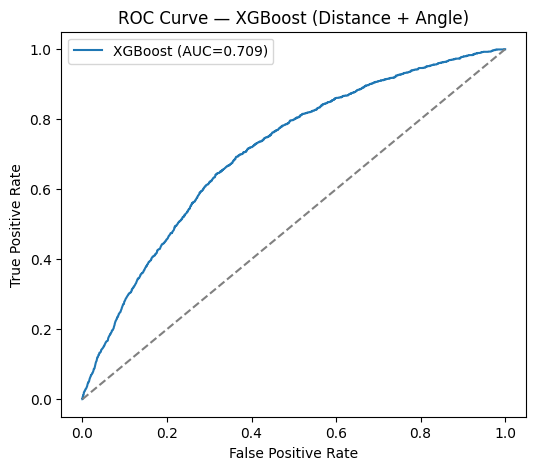

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fpr, tpr, _ = roc_curve(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Distance + Angle)")
plt.legend()
plt.show()

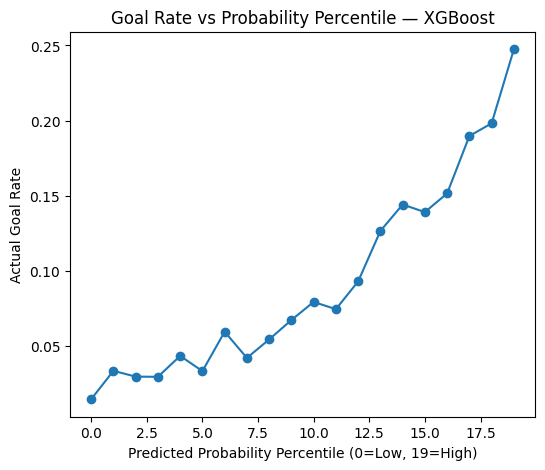

In [19]:
df_val = pd.DataFrame({"y_true": y_val, "y_pred": y_pred})
df_val["percentile"] = pd.qcut(df_val["y_pred"], 20, labels=False)

goal_rate = df_val.groupby("percentile")["y_true"].mean()
plt.figure(figsize=(6,5))
plt.plot(goal_rate.index, goal_rate.values, marker="o")
plt.xlabel("Predicted Probability Percentile (0=Low, 19=High)")
plt.ylabel("Actual Goal Rate")
plt.title("Goal Rate vs Probability Percentile — XGBoost")
plt.show()

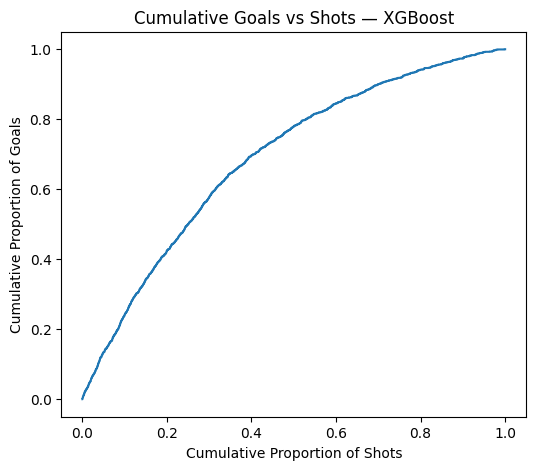

In [20]:
df_sorted = df_val.sort_values("y_pred", ascending=False)
df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
df_sorted["cum_shots_prop"] = np.arange(1, len(df_sorted)+1) / len(df_sorted)

plt.figure(figsize=(6,5))
plt.plot(df_sorted["cum_shots_prop"], df_sorted["cum_goals_prop"])
plt.xlabel("Cumulative Proportion of Shots")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Shots — XGBoost")
plt.show()

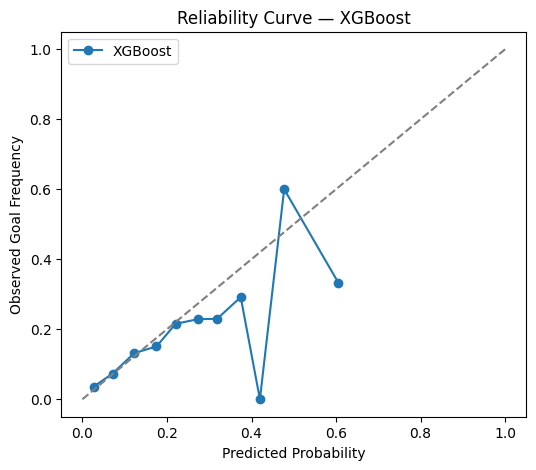

In [21]:
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=20)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.title("Reliability Curve — XGBoost")
plt.legend()
plt.show()